## MNIST FASHION DATASET

This is a subset of the MNIST Fashion dataset of Zalando's article images. In this dataset each example is a 28×28 grayscale image, along with an associated label from 4 classes:

0 => Sneaker

1 => Boot

2 => Shirt

3 => T-Shirt

Each image is 28 pixels in height and 28 pixels in width. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

The goal of this project is to build a model that can accurately classify new images into one of the 4 classes. We will employ Convolutional Neural Networks (CNNs) using Keras and a Tensflow backend.  

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import Keras dependencies

from keras.models import Sequential

from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D

from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# load in the training data and a small test set
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")
X_test = np.load("data/X_test.npy")

In [3]:
# There are 20,000 training examples each 28x28 pixels
X_train.shape

(20000, 28, 28)

In [4]:
# The labels for the training examples
y_train.shape

(20000,)

{0.0: 5000, 1.0: 5000, 2.0: 5000, 3.0: 5000}


<BarContainer object of 4 artists>

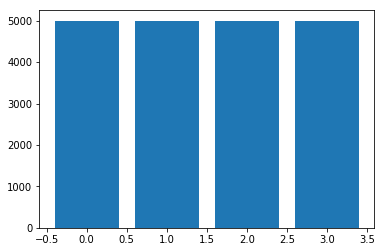

In [5]:
# check the class distribution in the training data
label, counts = np.unique(y_train, return_counts=True)
print(dict(zip(label, counts)))
plt.bar(label, counts)

In [6]:
# Let's look at the array for an image
X_train[0]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

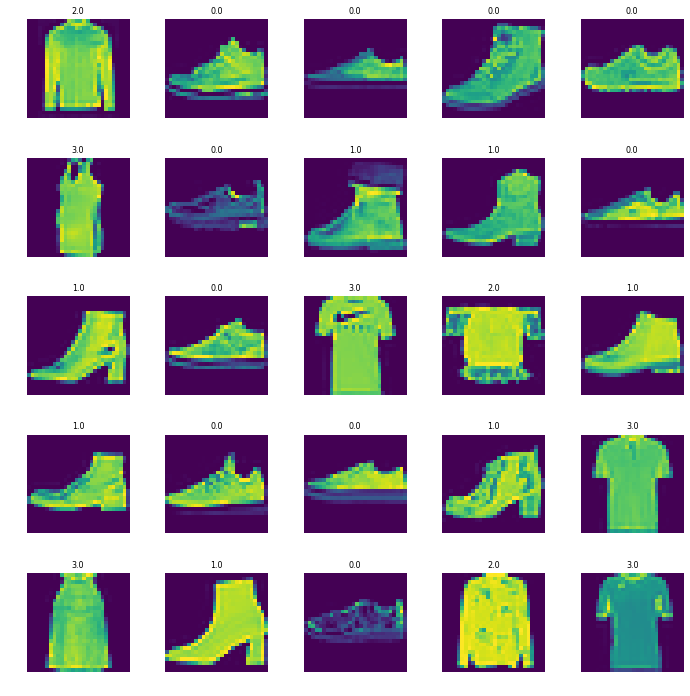

In [7]:
# We can plot a few images

fig, axes = plt.subplots(5, 5, figsize = (12,12))

axes = axes.ravel()

for i in np.arange(0, 25):

    # Select random indices from the training set
    index = np.random.randint(0, len(X_train))
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Lets prepare our data for the model. We are going to be using Convolutional Neural Networks, which are considered the model of choice for image processing. We will use Keras which is a deep learning library written in Python and capable of running on top of TensorFLow, CNTK or Theano. We will be using a TensorFlow backend.

First we need to normalize the training data by dividing by 255, and then we reshape the image data as shown below.

The label data is transformed into a sparse matrix where each row has one 1 at the label position

Here we use the Sequential API, where you  add one layer at a time, starting from the input.

THe convolutional layers pass filters across the input of each layer to look for important features in the data. The neural network learns the best filters for the problem. 
Here we use 32 filters for the two firsts conv2D layers and 64 filters for the third and fourth. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The pooling layer (MaxPooling2D) acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time).

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

Two fully-connected (Dense) layers are used which is just and artificial neural network (ANN) classifier. In the last layer the net outputs distribution of probability of each of the 4 classes.

In [8]:
# Normalize the input image data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [9]:
# Reshape the training data to have the correct shape for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_train.shape

(20000, 28, 28, 1)

In [10]:
# Transform the label data into a sparse matrix format
num_classes = 4
y_train = np_utils.to_categorical(y_train, num_classes)

In [21]:
# Split the data into Training and Validation sets so we can see how our model generalizes to unseen data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [11]:
# Instatiate a sequential model, where layers are added one at a time
cnn_model = Sequential()

# Add 2 convolutional layers with 32 filters each and then a Maxpooling layer
cnn_model.add(Conv2D(32,(5, 5), input_shape = (28,28,1), activation='relu'))
cnn_model.add(Conv2D(32,(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

# Add dropout for regularization
cnn_model.add(Dropout(0.25))

# Add another 2 convolutional layers with 64 filters each and a subsequent Maxpooling layer
cnn_model.add(Conv2D(64,(3, 3), activation='relu'))
cnn_model.add(Conv2D(64,(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

# Again add dropout for regularization
cnn_model.add(Dropout(0.25))

# Flatten the data into a single vector and add a dense layer followed by the output layer
# Output layer is a softmax to predict the 4 class probabilities for each training sample
cnn_model.add(Flatten())
cnn_model.add(Dense(activation = 'relu', units=32))
cnn_model.add(Dense(activation = 'softmax', units=4))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# We can take a look at the structure of the Neural Network and the number of parameters
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In this CNN we use categorical cross-entropy as the loss function (typical for multiclass classification) and an Adam optimizer

The Adam optimization algorithm is an extension to stochastic gradient descent (SGD). It combines the advantages of two other extensions of SGD, namely AdaGrad and RMSProp.

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient.

In [15]:
# Compile the model, choosing the loss function, optimizer and metrics
cnn_model.compile(loss ='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics =['accuracy'])

Better results are often achieved using annealing methods to gradually decrease the learning rate (LR) during training. 

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

A decreasing learning rate during training can help to efficiently reach the global minimum of the loss function.

Using the ReduceLROnPlateau function you can reduce the LR dynamically during training. Here we set it halve if the accuracy on the validation set isn't improved after 3 epochs.

In [16]:
# Add an annealing method to gradually reduce the LR during training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Below we train the model using a batch size of 64. This depends how much memory you have on your computer. With more memory you can increase the batch size which will speed up training.

In [25]:
epochs = 50
batch_size=64
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = 2,
                        validation_data = (X_val, y_val), callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/50
 - 94s - loss: 0.3742 - acc: 0.8463 - val_loss: 0.2972 - val_acc: 0.8740
Epoch 2/50
 - 89s - loss: 0.2695 - acc: 0.8820 - val_loss: 0.2269 - val_acc: 0.9140
Epoch 3/50
 - 91s - loss: 0.2469 - acc: 0.8932 - val_loss: 0.2091 - val_acc: 0.9035
Epoch 4/50
 - 87s - loss: 0.2258 - acc: 0.9034 - val_loss: 0.1966 - val_acc: 0.9140
Epoch 5/50
 - 87s - loss: 0.2112 - acc: 0.9072 - val_loss: 0.1864 - val_acc: 0.9190
Epoch 6/50
 - 87s - loss: 0.2051 - acc: 0.9099 - val_loss: 0.1848 - val_acc: 0.9250
Epoch 7/50
 - 89s - loss: 0.1996 - acc: 0.9119 - val_loss: 0.1802 - val_acc: 0.9260
Epoch 8/50
 - 88s - loss: 0.1899 - acc: 0.9154 - val_loss: 0.1743 - val_acc: 0.9285
Epoch 9/50
 - 88s - loss: 0.1834 - acc: 0.9204 - val_loss: 0.1637 - val_acc: 0.9310
Epoch 10/50
 - 88s - loss: 0.1792 - acc: 0.9221 - val_loss: 0.1668 - val_acc: 0.9260
Epoch 11/50
 - 88s - loss: 0.1700 - acc: 0.9263 - val_loss: 0.

Ok, so that's pretty good!. We get 97% accuracy on the training set and the model seems to generalize pretty well to get over 94% on the validation set.

Let's try modifying the model a little bit to see if we can further optimise it. Tuning a CNN can be complicated but as we had good results with our first model we won't modify the architecture too much. Here we add "padding", this essentially adds zeros around the edge of the image to ensure that the output length is the same as the input length.
We use a larger pooling size (3, 3), which means we decrese the image size by a larger factor. We also use increased dropout, which should add some regularisation. We the use a fully connected layer with 256 units and then dropout before the output layer.

In [17]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model2.add(Conv2D(64, (3,3), padding = 'Same', activation ='relu'))
model2.add(MaxPooling2D(pool_size=(3,3)))

model2.add(Dropout(0.35))

model2.add(Conv2D(64, (3,3), padding = 'Same', activation ='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Dropout(0.3))

model2.add(Flatten())
model2.add(Dense(256, activation = 'relu'))

model2.add(Dropout(0.4))

model2.add(Dense(4, activation = 'softmax'))

In [18]:
# Let's take a look at the architecture summary
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 64)          0         
__________

In [19]:
# Here we use the RMSprop optimizer
rmsprop = RMSprop()
model2.compile(loss = 'categorical_crossentropy', optimizer = rmsprop, metrics = ['accuracy'])

In [22]:
batch_size = 128
epochs = 50

model2 = model2.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, y_val), verbose = 2)

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/50
 - 37s - loss: 0.3908 - acc: 0.8341 - val_loss: 0.3211 - val_acc: 0.8755
Epoch 2/50
 - 38s - loss: 0.2630 - acc: 0.8839 - val_loss: 0.2184 - val_acc: 0.9130
Epoch 3/50
 - 38s - loss: 0.2238 - acc: 0.9012 - val_loss: 0.1751 - val_acc: 0.9255
Epoch 4/50
 - 38s - loss: 0.2133 - acc: 0.9085 - val_loss: 0.1851 - val_acc: 0.9215
Epoch 5/50
 - 38s - loss: 0.1961 - acc: 0.9154 - val_loss: 0.1520 - val_acc: 0.9305
Epoch 6/50
 - 38s - loss: 0.1883 - acc: 0.9179 - val_loss: 0.1494 - val_acc: 0.9360
Epoch 7/50
 - 38s - loss: 0.1777 - acc: 0.9231 - val_loss: 0.1387 - val_acc: 0.9385
Epoch 8/50
 - 38s - loss: 0.1750 - acc: 0.9255 - val_loss: 0.1523 - val_acc: 0.9285
Epoch 9/50
 - 38s - loss: 0.1697 - acc: 0.9253 - val_loss: 0.1369 - val_acc: 0.9415
Epoch 10/50
 - 38s - loss: 0.1616 - acc: 0.9323 - val_loss: 0.1372 - val_acc: 0.9455
Epoch 11/50
 - 38s - loss: 0.1573 - acc: 0.9314 - val_loss: 0.

Ok, so this model performs slightly better, but there's not much difference. It seems to generalize slightly better, but we must remember that our validation set isn't very big (2000 samples).
A script for this model can be found in the repo along with a run.py script which can be used to download the data, train the model and test on the small test set.

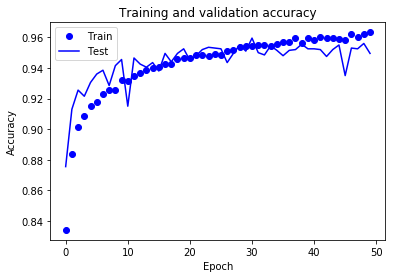

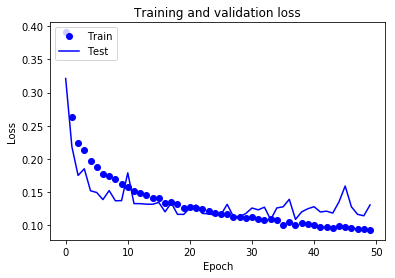

In [24]:
# We can plot the accuracy and loss curves during training for both the train and validation sets

accuracy = model2.history['acc']
val_accuracy = model2.history['val_acc']
loss = model2.history['loss']
val_loss = model2.history['val_loss']
epochs = range(len(accuracy))

# Plot training & validation accuracy values
plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, val_accuracy, 'b')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validation accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure()

# Plot training & validation loss values
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validation loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()